# [AI 이노베이션 스퀘어] 12기 고급 시각반
- github: https://github.com/hysKim1/AI_Vision
    - [파이썬 공식문서]https://docs.python.org/ko/3/
    - [Numpy 공식문서]https://numpy.org/devdocs/
    - [ML]https://developers.google.com/machine-learning/crash-course/ml-intro?hl=ko
    - [DL]https://www.tensorflow.org/?hl=ko
---    
* [Segmentation](#Segmentation)
    * [U-net](#U-net)
    * [Cycle GAN](#Cycle-GAN)

### U-net
FCN (Fully Convolutional Networks)
> - Dense는 Flatten하여 위치 정보를 잊음
- Dense layer 대신에 1x1 convolution 대체
- 입력 크기 상관 없음
- upsampling/convolution Transpose : segmentation 역할 원래 크기에서 어떤 클래스
- 원본 크기로 복원
segmentation 성능이 많이 좋지 않음

- U-net의 skip layer
  - Resnet 전전 데이터를 받아서 더 정확하게 segmentation
  - 대응하는 encoder,decoder 레이어 연결해서 훨씬 더 정확하게 segmentation 
- decoder 활용해서 데이터 생성에도 쓰임

### Image segmentation with a U-Net-like architecture

참고: https://keras.io/examples/vision/oxford_pets_image_segmentation/



In [ ]:
#Download the data

!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  28.5M      0  0:00:26  0:00:26 --:--:-- 30.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  9178k      0  0:00:02  0:00:02 --:--:-- 9178k


입력 이미지와 타겟 segmentation masks 의 paths 지정

In [ ]:
import os  #파일처리: os.path , pathlib 영상처리의 대용량 이미지 파일 관리 

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 4
batch_size = 32

#입력이미지 타겟이미지 불러오기 
input_img_paths = sorted( 
    [
        os.path.join(input_dir, fname)  #파일로 가져옴
        for fname in os.listdir(input_dir) 
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


입력 이미지와 해당하는 segmentation mask

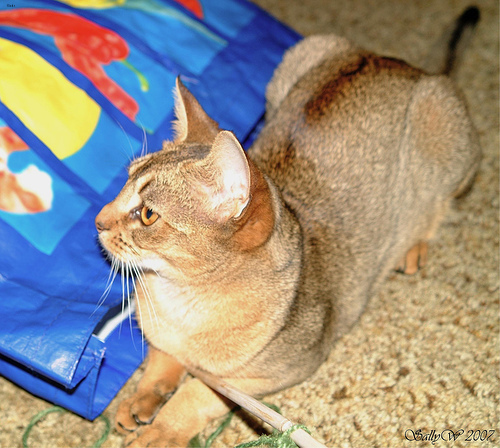

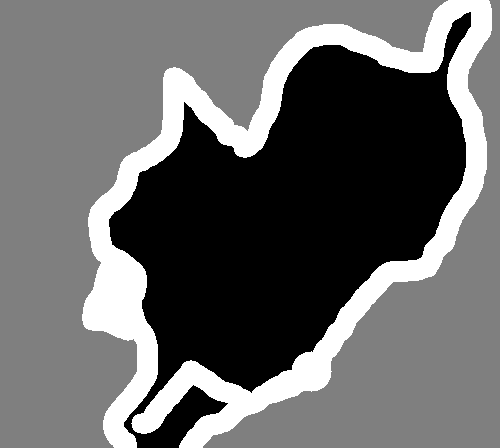

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# input image #7 시각화
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

 load & vectorize batches of data
 - Sequence class

In [ ]:
import tensorflow as tf
tf.keras.preprocessing.sequence  #언어 전처리 module

<module 'tensorflow.keras.preprocessing.sequence' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/preprocessing/sequence/__init__.py'>

In [ ]:
keras.utils.Sequence #class(객체)

tensorflow.python.keras.utils.data_utils.Sequence

복잡한 데이터 구조 
1. `tf.data.Dataset`  편리
2. `keras.utils.Sequence`
- keras 전용으로 넘파이 기반
-  `__len__`,`__getitem__`  indexing, slicing 가능해서 데이터셋을 효율적으로 관리하기 위해 객체로 관리
  - 데이터셋이 많은 경우에는 되는 경우 의미 없음
-  객체 자체를 indexing, slicing 안되는 경우가 많아서  상속하면 맞추기 편리하도록 지원 
get file, plot model, to categorical


In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img   #PIL.Open

# keras.utils.Sequence keras 전용(Numpy 기반)
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
# __len__,__getitem__  indexing 가능  
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        #핵심
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

In [ ]:
from collections import Sequence  #케라스,tf 에서 지원하는 클래스

In [ ]:
a={1,2} #__getitem__ 없어서 indexing, slicing 불가

Validation data 구성

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## U-Net Xception-style model
- light weight model
- encoder - decoder
- skip layer : 대응하는 레이어에서도 받음
 - 활용 어려움

### SeparableConv2D
-  convolution 경량화를 위해서 filter 를 분리해서 계산 복잡도를 줄여서 빨라지나 성능 문제 생김
  - convolution 좌우가 아님  좌우/상하로 쪼개서 계산
  - 계산 복잡도 줄이나 성능의 문제때문에 DNN에서 중간에 사용

In [ ]:
model= tf.keras.applications.Xception() #전이학습 가능하나 직접 구현

91889664/91884032 [==============================] - 4s 0us/step


In [ ]:
model.summary() #파라미터 갯수 2백만개 이상
#중간에 늘어나고 줄어드는 부분이 있음 upsampling & conv2DTranspose 섞어 씀

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
len(model.layers) #resnet보다는 레이어가 적음

134

In [ ]:
#clear_session
# 실행할때마다 모델의 이름이 변경됨
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Dense(12,input_shape=(2,2))
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2, 12)             36        
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()#메모리내 모두 지워버림

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block 
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x) # BN +activation
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x) # convolution 경량화
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()  #

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

### ㅅTraining

In [ ]:
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# 모델 학습하고 각 epoch 끝날때마다 validation
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)


Epoch 1/15
199/199 [==============================] - 63s 317ms/step - loss: 1.1554 - val_loss: 2.6376
Epoch 2/15
199/199 [==============================] - 63s 315ms/step - loss: 0.5124 - val_loss: 2.1695
Epoch 3/15
199/199 [==============================] - 62s 314ms/step - loss: 0.4313 - val_loss: 0.4186
Epoch 4/15
199/199 [==============================] - 62s 314ms/step - loss: 0.3935 - val_loss: 0.3993
Epoch 5/15
199/199 [==============================] - 62s 313ms/step - loss: 0.3540 - val_loss: 0.3998
Epoch 6/15
199/199 [==============================] - 63s 314ms/step - loss: 0.3246 - val_loss: 0.3978
Epoch 7/15
199/199 [==============================] - 63s 315ms/step - loss: 0.2990 - val_loss: 0.3911
Epoch 8/15
199/199 [==============================] - 63s 314ms/step - loss: 0.2787 - val_loss: 0.3674
Epoch 9/15
199/199 [==============================] - 62s 314ms/step - loss: 0.2577 - val_loss: 0.3901
Epoch 10/15
199/199 [==============================] - 62s 314ms/step - l

### Prediction

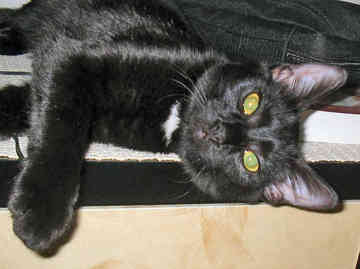

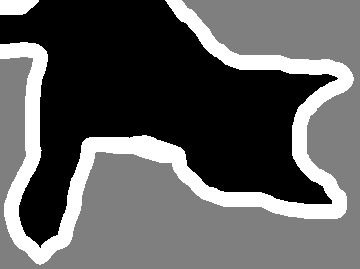

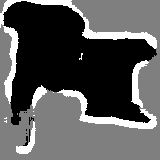

In [ ]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

#입력이미지
display(Image(filename=val_input_img_paths[i]))

# 실제 mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# 모델이 예측한 mask 시각화
display_mask(i)  # Note that the model only sees inputs at 150x150.

### Oxford Pets Datasets
-  Image Classification
annotation
- 학습 데이터의 클래스 
- 데이터가 폴더 구조로 되어 있으면 클래스를 알 수 있으나 안되는 경우 annotation으로 class mapping 해서 구분
- 이름으로도 가능(pandas 사용 가능)
1: Cat
2: Dog
Abyssinian _199 1 1 1

https://keras.io/examples/vision/oxford_pets_image_segmentation/

### Cycle GAN 
- DCGAN: deep convolution gan
- pix2pix conditional gan
  - 성능은 나쁘지 않으나 데이터가 짝을 이뤄야함
  - 데이터 셋 구하기 힘듦

- 일반적인 사람과 비슷한 생성모델로 역사적으로 가능성 열어줌
  - UC Berkeley 2017~2020까지 다양한 시험해보고 피드백 받고 논문 업데이트

- GAN: generator, discriminator 
- 예.화풍을 사진처럼 만듦
- 예. 얼룩말을 말로 서로 바꿈
- **generator, discriminator 역할 동시에** 함
  - 학습이 잘 안되기 때문에 loss function 중요

style transfer 와 거의 비슷
- real photos 실제 사진 같음
-  말<-> 얼룩말 
  - 말에 사람이 타고 있으면 사람도 얼룩말로 인식
  
GAN 변형
참고: https://www.tensorflow.org/tutorials/generative/cyclegan


### Cycle GAN 
- CYCLE: 한 이미지의 도메인 특성을 다른 이미지 도메인으로 변환
- 예. 말을 얼룩말로 서로 바꾸어 줄 수 있음

논문: [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593)

차이점
- **짝을 이루지 않더라도** 고유한 특성에 따라서 Style transfer 하는 방법
- Cyclegan 배치 정규화 대신 인스턴스 정규화
-  수정 된 resnet 기반 생성기를 사용
- 2 개의 생성기 (G & F)와 2 개의 판별기 (X & Y)
    - $(G:X -> Y)$ 생성기 G 는 이미지 X 를 이미지 Y 로 변환하는 방법 학습
    - $(F:Y -> X)$ 생성기 F 는 이미지 Y 를 이미지 X 로 변환하는 방법 학습 
    - 판별 기 D_X 는 이미지 X 와 생성 된 이미지 X ( F(Y) )를 구별하는 방법을 학습.
    - 판별 기 D_Y 는 이미지 Y 와 생성 된 이미지 Y ( G(X) )를 구별하는 D_Y 학습.
-  Cycle-Consistent Adversarial Networks
    - Cycle Consistencey loss:결과가 원래 입력에 가까워야함
        - 변환한 이미지를 다시 되돌리는 경우 원래 이미지와 동일해야함

        - forward cycle consistency loss: $X -> G(X) ->F(G(X)) ~  \hat X$
        - backward cycle consistency loss: $Y-> F(Y) ->G(F(Y)) ~  \hat Y$
    - $Identity loss = |G(Y)-Y|+|F(X)-X|$
    -  $(G:X -> Y)$  Y 이미지를 생성기 G에 공급하면 Y 에 가까운 이미지를 생성.

- pix2pix보다 결과가 잘 안나옴

참고: https://www.tensorflow.org/tutorials/generative/cyclegan

- 참고 : https://www.tensorflow.org/tutorials/generative/cyclegan

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git #tensorflow_example package 

In [ ]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE # tensor의 속도 자동 최적화

### 입력 파이프 라인
1. tensorflow_datasets 데이터 불러오기
2. train, tests 데이터셋 구성
3. data augmentation
  -  정확도 보다는 **과적합 줄이는** 용도로 사용
  - 랜덤성 보장으로 일반화된 모델
    - random jittering
    - random mirroring  랜덤 좌우반전 중요( transitional invariance 한 성질 때문에)
  > - pix2pix 랑 유사함


In [ ]:
#tensorflow_datasets options
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)
 #지도학습용 데이터와 메타 데이터 가져옴

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete8B84Y9/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete8B84Y9/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete8B84Y9/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0.incomplete8B84Y9/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/horse2zebra/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image
  

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
#AUTOTUNE,cache 결과 임시로 저장해서 속도 향상 
# cycle GAN 에서는 학습이 왔다갔다 해서 `cache` test 에도 적용
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

In [ ]:
#대용량Dataset을 for문 break 처럼 하나씩 데이터 확인용 
sample_horse = next(iter(train_horses)) 
sample_zebra = next(iter(train_zebras))

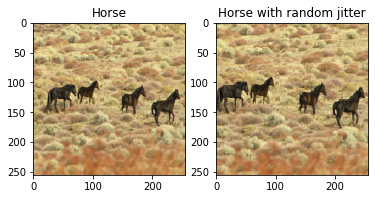

In [ ]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) * 0.5 + 0.5)

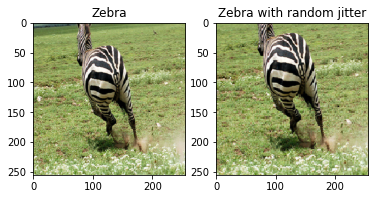

In [ ]:
plt.subplot(121)
plt.title('Zebra')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)
 
plt.subplot(122)
plt.title('Zebra with random jitter') #랜덤성 보장 
plt.imshow(random_jitter(sample_zebra[0]) * 0.5 + 0.5)

Cycle GAN 모델 구조
 - 다른 모델을 일부분만 가져옴
 - instance normalizaiton
  > - pix2pix batch normalization 
- 논문에서는 ResNet 기반 
- 이미지 페어링 불필요
- 생성기와 판별기 역할을 둘다 함
- 생성기A는 생성도 하고 판별도 가능 

In [ ]:
OUTPUT_CHANNELS = 3
# 모델 generator, discriminator 따로 구현해서 재활용

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # if  
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

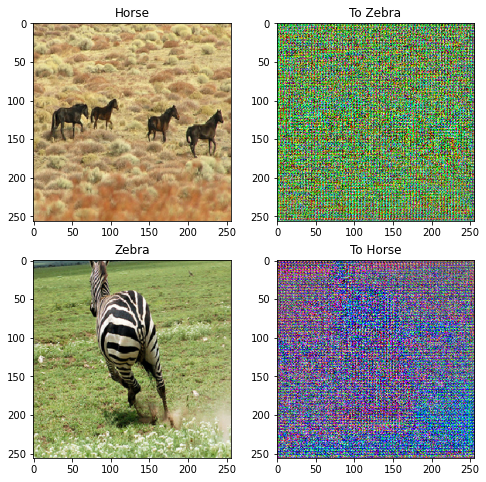

In [ ]:
#학습전 생성한 이미지 
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

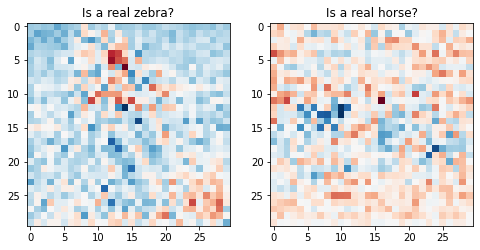

In [ ]:
#학습전 판별
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Loss Function
- multi-task loss
- loss 동시에 줄이면 문제 생김.
    - 예. Total Error = Variance + Bias (trade-off 관계)

1. discriminator_loss
  - hyper-parameter: loss 가중치로 조절(유의미)
    - 0.5 
  > - 미분에서 상수가 중요한 경우가 있음
        - 미분 할때 아름답게 보여주기 위한 테크닉
      - 독단적인 경우 상수가 중요하지 않음
      - 머신러닝은 절대적 값을 구할 수 없다.
2. generator_loss

  

In [ ]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real) #GT 1

  generated_loss = loss_obj(tf.zeros_like(generated), generated) #생성(가짜) 0

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5  # 0.5 가중치로 조절

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

3. calc_cycle_loss
- pix2pix 의 loss 인 MAE (Mean Absolute Erorr) 사용
- 일관성(consistency)
- identity loss: instance normalization

4. identity_loss


In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
# 2개의 generator, discrimiantor 학습 
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 40

def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


1. 예측
2. loss 4개 구해서 합침
3. 각 쌍으로 이루어진거 G,D 4개 동시 학습


In [ ]:
@tf.function
def train_step(real_x, real_y):
  #persistent=True 해서 GradientTape 여러번 사용 
  #gradientTape 1개로 동시에 순차적으로 학습( 2개사용시 for 사용해서 학습가능)
  with tf.GradientTape(persistent=True) as tape: 
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

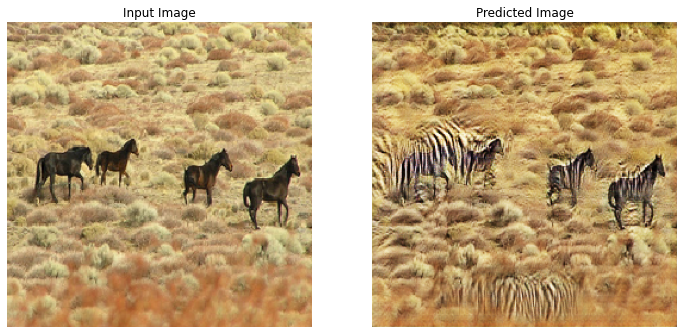

Time taken for epoch 14 is 454.3728210926056 sec

......

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))
  
  #결과물이 너무 안 좋아서 학습 200번이상..

In [ ]:
# Run the trained model on the test dataset
for inp in test_horses.take(5):
  generate_images(generator_g, inp)

- 학습시간 오래걸리니 어떻게 될지 몰라 checkpoint 기록
- 논문에서는 ResNet 152 layers로 학습 오래걸림